# Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma
import seaborn as sns

# Load the monthly mean total sunspot number

In [ ]:
rng = np.random.default_rng(42)

url = "https://www.sidc.be/silso/DATA/SN_m_tot_V2.0.txt"

cols = ["year", "month", "decimal_date", "sunspot",
        "std", "n_obs", "provisional"]
df = pd.read_csv(
    url,
    delim_whitespace=True,
    header=None,
    names=cols,
    comment='%',  # in case there are commented lines
)

/tmp/ipython-input-1832291807.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


# Create a proper datetime index

In [ ]:
df = df[(df["year"] >= 1749) & ((df["year"] < 2019) | ((df["year"] == 2018) & (df["month"] <= 11)))]
df["date"] = pd.to_datetime(dict(year=df.year, month=df.month, day=1))
df = df.set_index("date")

# Step 1. Plot the data over the years to see what the distribution might be like

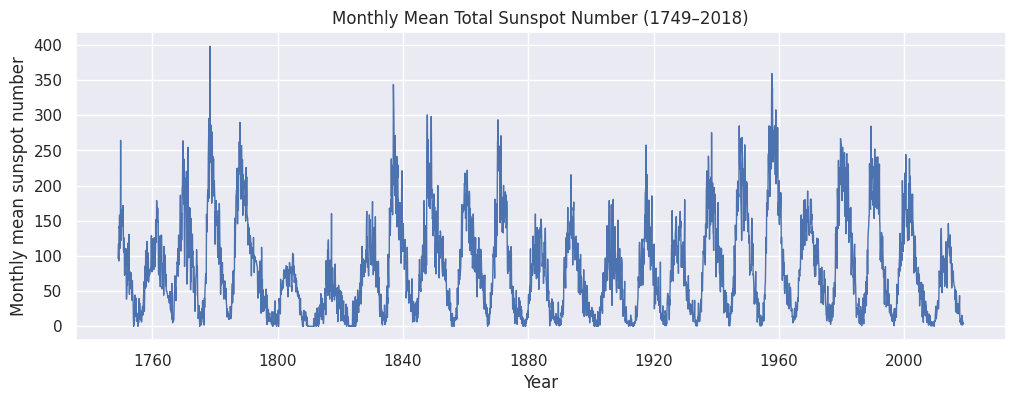

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(12,4))
sns.lineplot(data=df, x=df.index, y="sunspot", linewidth=1)
plt.xlabel("Year")
plt.ylabel("Monthly mean sunspot number")
plt.title("Monthly Mean Total Sunspot Number (1749–2018)")
plt.show()

# Step 2. Model the phenomenon with a gamma distribution, with a new cycle resetting every 12 years
We’ll assume sunspot numbers in a cycle follow a Gamma(a, b) and that a new cycle starts every 12 years.

In [ ]:
first_year = df["year"].min()
df["cycle_id"] = (df["year"] - first_year) // 12

cycle_params = []

for cid, group in df.groupby("cycle_id"):
    data = group["sunspot"].values
    data = data[data > 0]      # ✅ FIX: remove zero values

    a_hat, loc_hat, scale_hat = gamma.fit(data, floc=0)
    b_hat = 1.0 / scale_hat

    cycle_params.append((cid, a_hat, b_hat))

cycle_params[:5]

[(0, 1.967849466130582, np.float64(0.026715975151111335)),
 (1, 2.279457408867829, np.float64(0.02268618454031899)),
 (2, 1.2122152971202824, np.float64(0.012573661733449417)),
 (3, 1.999881656927757, np.float64(0.0173550621081379)),
 (4, 1.5337983044164207, np.float64(0.03572696500788806))]

# Step 3. Histogram of sunspot counts

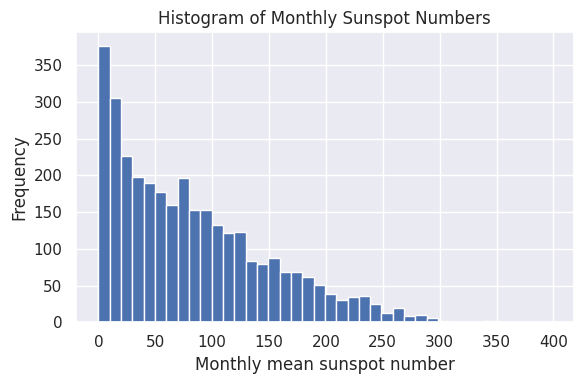

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(df["sunspot"], bins=40)
plt.xlabel("Monthly mean sunspot number")
plt.ylabel("Frequency")
plt.title("Histogram of Monthly Sunspot Numbers")
plt.tight_layout()
plt.show()

# Step 4. a=4, and b =10 so plot MNMC for groups: First 50 samples, All samples, Last 50 samples

In [ ]:
def log_posterior_gamma_ab(y, a, b):
    """
    Log posterior for Gamma(a, b) assuming:
    y_i ~ Gamma(a, b) with pdf(y|a,b) = b^a / Γ(a) * y^(a-1) * exp(-b y), y>0
    Prior: p(a,b) ∝ 1/(1+a^2) * 1/(1+b^2) (weakly informative proper-ish prior)
    """
    if a <= 0 or b <= 0:
        return -np.inf

    y = np.asarray(y)
    n = len(y)

    # log likelihood: sum over i
    # log p(y|a,b) = n[a ln b - ln Γ(a)] + (a-1) sum ln y_i - b sum y_i
    sum_log_y = np.sum(np.log(y + 1e-9))   # small epsilon to avoid log(0)
    sum_y = np.sum(y)

    from scipy.special import gammaln
    ll = n * (a * np.log(b) - gammaln(a)) + (a - 1) * sum_log_y - b * sum_y

    # simple log prior: log p(a) + log p(b) ~ -log(1+a^2) -log(1+b^2)
    lp = -np.log(1 + a**2) - np.log(1 + b**2)

    return ll + lp


def mcmc_gamma_ab(y, a0=4.0, b0=10.0, n_iter=5000, proposal_scale=(0.2, 0.2)):
    """
    Random-walk Metropolis-Hastings sampler for (a, b).
    proposal: a' = |a + N(0, s_a^2)|, b' = |b + N(0, s_b^2)|
    """
    y = np.asarray(y)
    a_chain = np.zeros(n_iter)
    b_chain = np.zeros(n_iter)

    a_curr = a0
    b_curr = b0
    log_post_curr = log_posterior_gamma_ab(y, a_curr, b_curr)

    s_a, s_b = proposal_scale

    for i in range(n_iter):
        # propose
        a_prop = abs(a_curr + rng.normal(0, s_a))
        b_prop = abs(b_curr + rng.normal(0, s_b))

        log_post_prop = log_posterior_gamma_ab(y, a_prop, b_prop)

        # acceptance prob
        log_alpha = log_post_prop - log_post_curr
        if np.log(rng.uniform()) < log_alpha:
            a_curr, b_curr, log_post_curr = a_prop, b_prop, log_post_prop

        a_chain[i] = a_curr
        b_chain[i] = b_curr

    return a_chain, b_chain

# --- 3 data groups ---
y_first50 = df["sunspot"].iloc[:50].values
y_all = df["sunspot"].values
y_last50 = df["sunspot"].iloc[-50:].values

# Run MCMC
a_first, b_first = mcmc_gamma_ab(y_first50, a0=4, b0=10)
a_all, b_all = mcmc_gamma_ab(y_all, a0=4, b0=10)
a_last, b_last = mcmc_gamma_ab(y_last50, a0=4, b0=10)


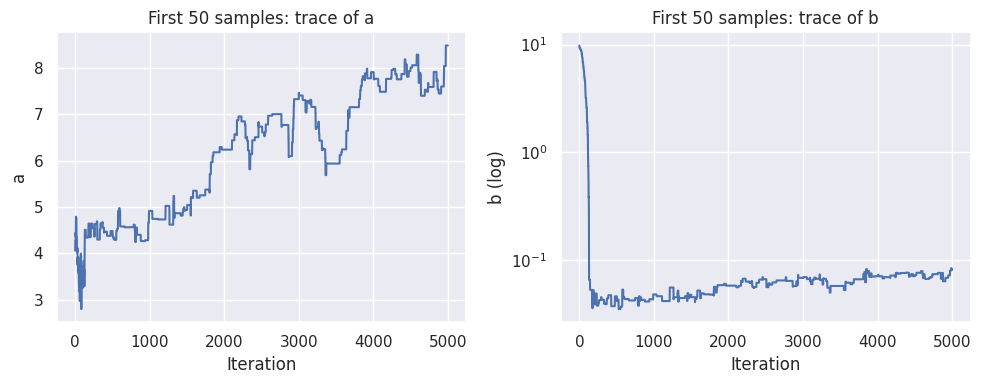

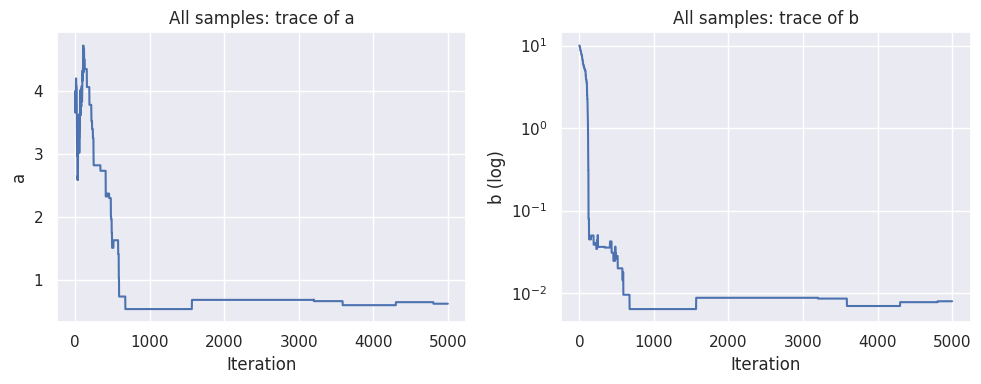

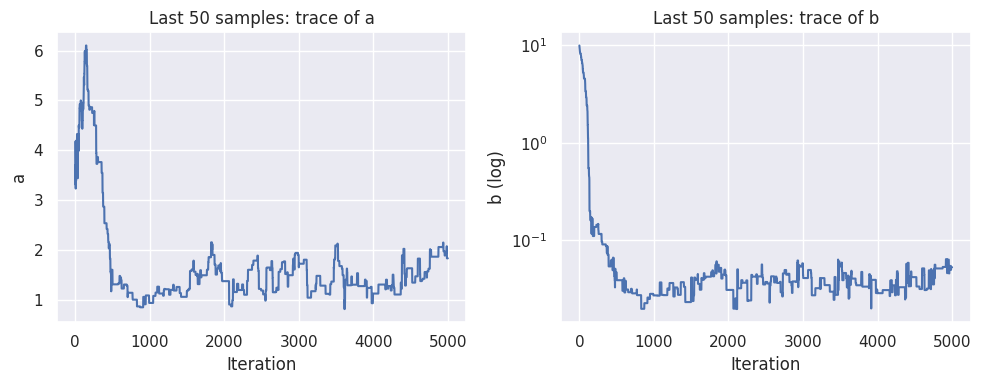

In [ ]:
def plot_traces(a_chain, b_chain, title_prefix):
    iters = np.arange(len(a_chain))

    plt.figure(figsize=(10, 4))

    # a trace
    plt.subplot(1, 2, 1)
    plt.plot(iters, a_chain)
    plt.xlabel("Iteration")
    plt.ylabel("a")
    plt.title(f"{title_prefix}: trace of a")

    # b trace (log scale fix)
    plt.subplot(1, 2, 2)
    plt.plot(iters, b_chain)
    plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel("b (log)")
    plt.title(f"{title_prefix}: trace of b")

    plt.tight_layout()
    plt.show()
plot_traces(a_first, b_first, "First 50 samples")
plot_traces(a_all, b_all, "All samples")
plot_traces(a_last, b_last, "Last 50 samples")

# Step 5. Visualise the traces of and b and the histogram of the traces. [Here you are going to drop some values known as burn out]

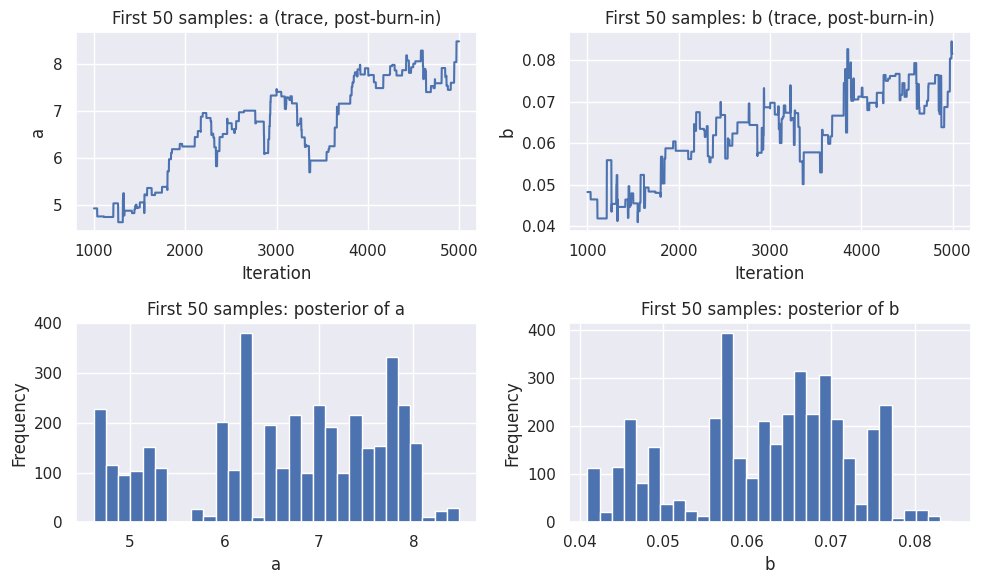

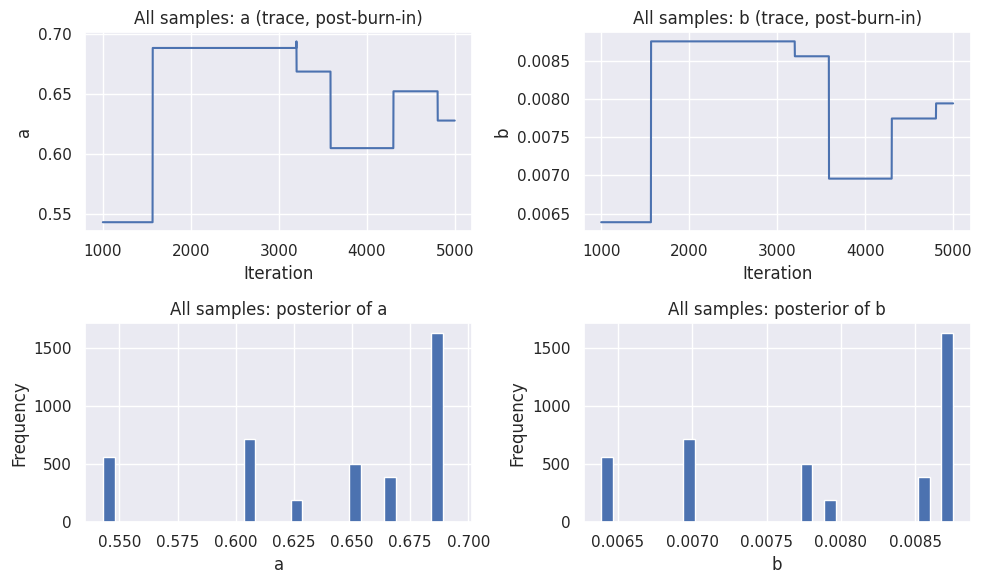

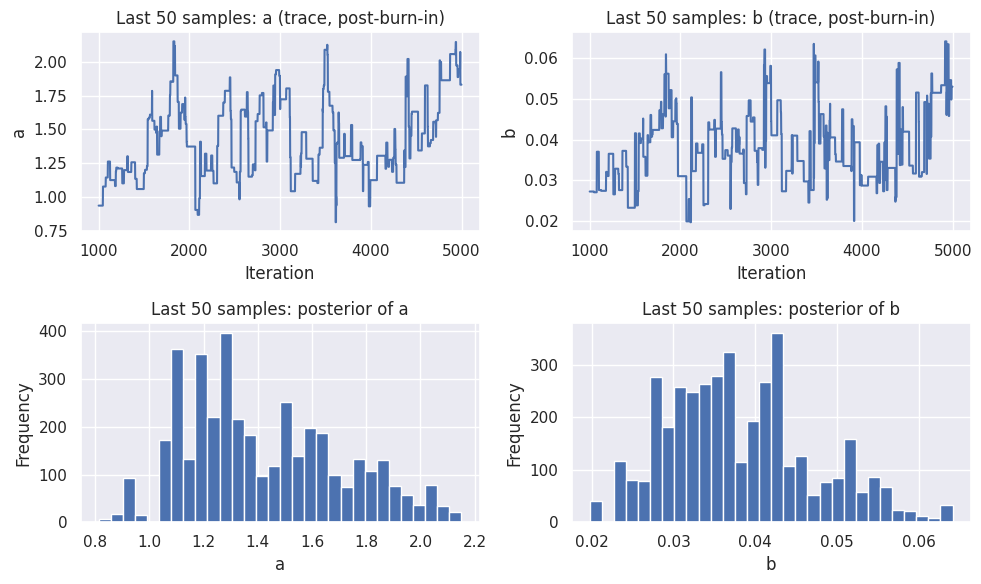

In [ ]:
burn = 1000

def plot_posterior(a_chain, b_chain, title_prefix):
    a_post = a_chain[burn:]
    b_post = b_chain[burn:]

    # Trace after burn-in
    iters = np.arange(burn, len(a_chain))

    plt.figure(figsize=(10, 6))

    # trace of a
    plt.subplot(2, 2, 1)
    plt.plot(iters, a_post)
    plt.xlabel("Iteration")
    plt.ylabel("a")
    plt.title(f"{title_prefix}: a (trace, post-burn-in)")

    # trace of b
    plt.subplot(2, 2, 2)
    plt.plot(iters, b_post)
    plt.xlabel("Iteration")
    plt.ylabel("b")
    plt.title(f"{title_prefix}: b (trace, post-burn-in)")

    # hist of a
    plt.subplot(2, 2, 3)
    plt.hist(a_post, bins=30)
    plt.xlabel("a")
    plt.ylabel("Frequency")
    plt.title(f"{title_prefix}: posterior of a")

    # hist of b
    plt.subplot(2, 2, 4)
    plt.hist(b_post, bins=30)
    plt.xlabel("b")
    plt.ylabel("Frequency")
    plt.title(f"{title_prefix}: posterior of b")

    plt.tight_layout()
    plt.show()

plot_posterior(a_first, b_first, "First 50 samples")
plot_posterior(a_all, b_all, "All samples")
plot_posterior(a_last, b_last, "Last 50 samples")


# Step 6. Prediction time of a and b

In [ ]:
def posterior_summary(a_chain, b_chain, burn=1000):
    a_post = a_chain[burn:]
    b_post = b_chain[burn:]

    return {
        "a_mean": np.mean(a_post),
        "a_median": np.median(a_post),
        "a_95ci": np.percentile(a_post, [2.5, 97.5]),
        "b_mean": np.mean(b_post),
        "b_median": np.median(b_post),
        "b_95ci": np.percentile(b_post, [2.5, 97.5]),
    }

summary_first = posterior_summary(a_first, b_first)
summary_all = posterior_summary(a_all, b_all)
summary_last = posterior_summary(a_last, b_last)

print("First 50 samples:", summary_first)
print("All samples:", summary_all)
print("Last 50 samples:", summary_last)

First 50 samples: {'a_mean': np.float64(6.6323912989290585), 'a_median': np.float64(6.769464343506032), 'a_95ci': array([4.73358633, 8.05726395]), 'b_mean': np.float64(0.062193429202232094), 'b_median': np.float64(0.0638167630670696), 'b_95ci': array([0.04184801, 0.07667253])}
All samples: {'a_mean': np.float64(0.6436494673789257), 'a_median': np.float64(0.6689114199934547), 'a_95ci': array([0.54289576, 0.68866315]), 'b_mean': np.float64(0.007913878934357875), 'b_median': np.float64(0.008559796540186054), 'b_95ci': array([0.00638825, 0.00875476])}
Last 50 samples: {'a_mean': np.float64(1.421295465846902), 'a_median': np.float64(1.3640134641823172), 'a_95ci': array([0.93527439, 2.05646329]), 'b_mean': np.float64(0.03799250647927083), 'b_median': np.float64(0.03678150493389219), 'b_95ci': array([0.02330284, 0.05655662])}
